<h1> Mixing Correlation and Mutual Information

Updates : 2 kinds of ranking proposed

Of course, SHAP is a great tool to get a lot of insights.
wti 200 has published a very interesting notebook: https://www.kaggle.com/code/wti200/analysing-interactions-with-shap
But some time a quick and "dirty" snapshot can be useful.

It may not be usual to mix parametric and non-parametric measurements and as I am neither a statistician nor a DataScientist I can do it without hesitation I will be forgiven  :-)) 

As described in its documentation, MI function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances. As for the correlation, I guess there is no need to explain what it is :-))

The results in this notebook are already well known, but it could give for future data a VERY quick insight

In [22]:
import numpy as np 
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from matplotlib import cm
import matplotlib.pyplot as plt

In [23]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')

In [24]:
for i in range(10):
    train[f'ch{i}'] = train.f_27.str.get(i).apply(ord) - ord('A')
# unique_characters feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model :
train["unique_c"] = train.f_27.apply(lambda s: len(set(s)))

# From https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras :
train['i_02_21'] = (train.f_21 + train.f_02 > 5.2).astype(int) - (train.f_21 + train.f_02 < -5.3).astype(int)
train['i_05_22'] = (train.f_22 + train.f_05 > 5.1).astype(int) - (train.f_22 + train.f_05 < -5.4).astype(int)
i_00_01_26 = train.f_00 + train.f_01 + train.f_26
train['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)

<h2> Mutual Info

In [25]:
x = train.loc[:100000].drop(['target','f_27'],axis=1)
y = train.loc[:100000]['target'].copy()

mi_scores = mutual_info_classif(x, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
mi_scores = mi_scores.sort_values(ascending=False)

<h2> Correlation

In [26]:
corr = np.absolute(train.corr()['target']).sort_values(ascending=False)

<h2> Ranking by average

In [27]:
score_mean = pd.DataFrame()
score_mean['name'] = corr.index.tolist()[1:16] # for the first 15 features
score_mean['corr'] = corr[1:16].values/np.max(corr[1:])*10
mi = pd.DataFrame()
mi['mi'] = mi_scores.values/np.max(mi_scores)*10
mi['name'] = mi_scores.index.tolist()
score_mean = score_mean.merge(mi,how = 'inner',on =['name']) 
score_mean['rank'] = (score_mean['corr'] + score_mean['mi'])/2  # the mean is just to get a rank (otherwise it means nothing)
score_mean.sort_values(by = ['rank'], axis=0, ascending=False)

,name,corr,mi,rank
0,i_00_01_26,10.000000,8.606439,9.303220
4,unique_c,6.376913,10.000000,8.188457
1,i_02_21,8.164985,6.353047,7.259016
2,ch9,6.974056,5.517569,6.245813
3,i_05_22,6.679342,4.234161,5.456751
5,f_21,5.924470,3.121477,4.522973
6,ch8,5.195306,2.656278,3.925792
8,ch0,4.535562,2.607230,3.571396
7,ch7,4.783806,1.984907,3.384357
13,f_11,3.554362,2.606896,3.080629


<h2> Ranking by pd.rank()

In [28]:
score_rank = pd.DataFrame()
score_rank['name'] = corr.index.tolist()[1:16] # for the first 15 features
score_rank['corr'] = corr[1:16].rank().values
mi = pd.DataFrame()
mi['mi'] = mi_scores.values
mi['name'] = mi_scores.index.tolist()
score_rank = score_rank.merge(mi,how = 'inner',on =['name'])
score_rank['mi'] = score_rank['mi'].rank()
score_rank['rank'] = (score_rank['corr']+ score_rank['mi'])/2   
score_rank.sort_values(by = ['rank'], axis=0, ascending=False)

,name,corr,mi,rank
0,i_00_01_26,15.0,14.0,14.5
1,i_02_21,14.0,13.0,13.5
4,unique_c,11.0,15.0,13.0
2,ch9,13.0,12.0,12.5
3,i_05_22,12.0,11.0,11.5
5,f_21,10.0,10.0,10.0
6,ch8,9.0,9.0,9.0
8,ch0,7.0,8.0,7.5
7,ch7,8.0,6.0,7.0
9,f_19,6.0,3.0,4.5


<h2> Visualization

In [29]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def quick_view(df):
    df_name = get_df_name(df)
    fig, ax = plt.subplots(figsize=(12,12))
    x = df['corr']
    y = df['mi']
    n = df['name']

    ax.scatter(x, y,s = 100*x,c=df['rank'],alpha=0.8, cmap=cm.coolwarm)
    plt.xlabel('target correlation Ranking',fontsize=15)
    plt.ylabel('target Mutual Information Ranking',fontsize=15)
    plt.title('\nImportant Features for DataFrame :"{}"\n'.format(df_name),fontsize=25)
    for i in range(df.shape[0]):
        ax.annotate(n[i], (x[i],y[i]),fontsize=15)

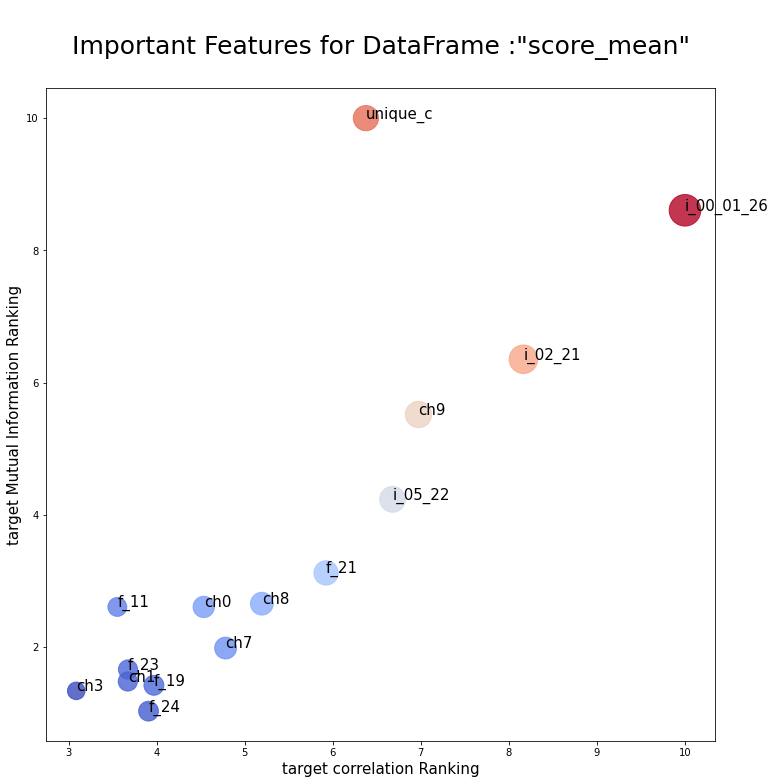

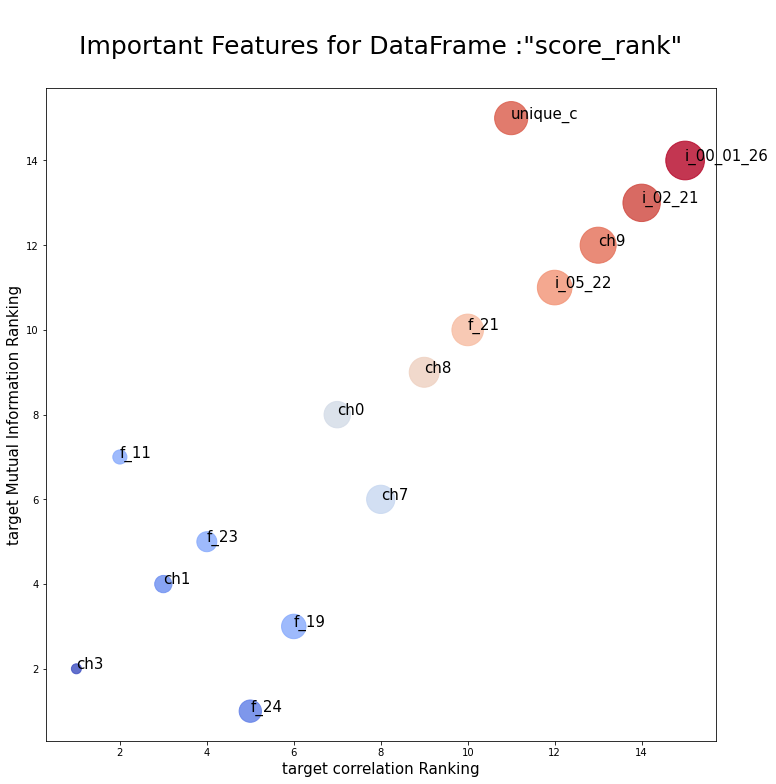

In [30]:
quick_view(score_mean)
quick_view(score_rank)